In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, mannwhitneyu

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [2]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/396008/hw_bootstrap.csv', sep=';')
df

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control
...,...,...,...
995,996,1000,Treatment
996,997,1200,Treatment
997,998,1500,Treatment
998,999,2000,Treatment


In [3]:
df = df.drop(columns=df.columns[0])
df.head()

,value,experimentVariant
0,"10,3804953740268",Control
1,"9,54686666784264",Control
2,"11,0882146509904",Control
3,"10,1472740570122",Control
4,"9,78980767524929",Control


In [4]:
df.dtypes

value                object
experimentVariant    object
dtype: object

In [5]:
df['value'] = df['value'].str.replace(',', '.').astype('float')
df.head()

,value,experimentVariant
0,10.380495,Control
1,9.546867,Control
2,11.088215,Control
3,10.147274,Control
4,9.789808,Control


In [6]:
df.dtypes

value                float64
experimentVariant     object
dtype: object

In [7]:
df_control = df.query('experimentVariant == "Control"').reset_index(drop=True)['value']
df_control

0      10.380495
1       9.546867
2      11.088215
3      10.147274
4       9.789808
         ...    
495    10.973929
496    10.261074
497     8.780090
498    11.169078
499    11.499566
Name: value, Length: 500, dtype: float64

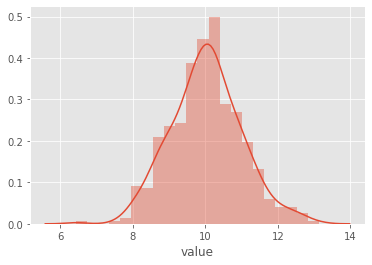

In [8]:
sns.distplot(df_control)

Распределение признака в контрольной группе нормальное 

In [9]:
df_test = df.query('experimentVariant == "Treatment"').reset_index(drop=True)['value']
df_test

0        10.380495
1         9.546867
2        11.088215
3        10.147274
4         9.789808
          ...     
495    1000.000000
496    1200.000000
497    1500.000000
498    2000.000000
499    3000.000000
Name: value, Length: 500, dtype: float64

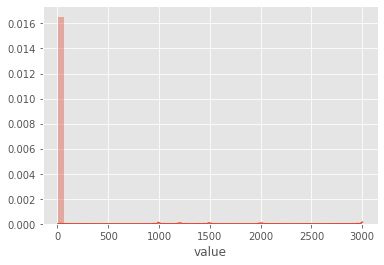

In [10]:
sns.distplot(df_test)

Распределение признака в тестовой группе не является нормальным, заметны выбросы

### Объявляем функцию, которая позволит проверять гипотезы с помощью бутстрапа

In [11]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

### Сравниваем средние значения в тестовой и контрольной группах с помощью бутстрапа
H0: Средние значения в двух группах не различаются

H1: Средние значения различаются

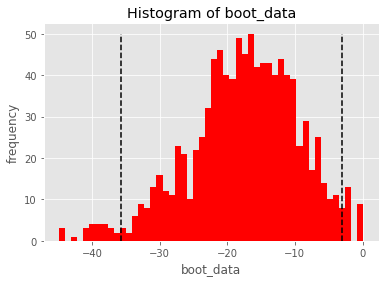

In [12]:
booted_data_means = get_bootstrap(
                        df_control, 
                        df_test, 
                        boot_it = 1000, 
                        statistic = np.mean) # в результате хранится разница двух распределений, ДИ и p-value

In [13]:
booted_data_means["p_value"]

0.029532057493980787

In [14]:
booted_data_means["quants"]

,0
0.025,-35.655858
0.975,-2.979682


### Вывод по бутстрапу (np.mean): 
Средние значения в тестовой и контрольной группах различаются на заданном уровне значимости, поскольку в 95-процентный доверительный интервал не попадает нулевое значение разницы между двумя средними.

p-value < 0.05 говорит о том, что при условии верности нулевой гипотезы о равенстве средних в двух группах вероятность получить такое или еще большее отклонение разницы* от 0 составляет менее 5%. То есть полученная нами разница оказалась бы достаточно редким явлением, если бы средние двух групп на самом деле были равны. Значит, мы имеем основание отвергнуть нулевую гипотезу в пользу альтернативной.

*Полученная нами разница - это средняя разница между средними значениями бутстрап-выборок.

### Сравниваем медианы в тестовой и контрольной группах с помощью бутстрапа
H0: Медианы в двух группах не различаются

H1: Медианы различаются

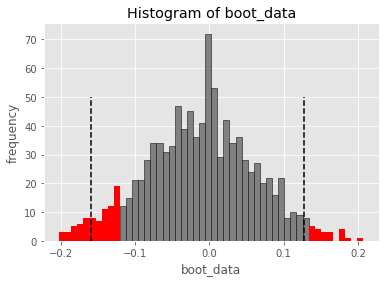

In [15]:
booted_data_medians = get_bootstrap(
                          df_control, 
                          df_test, 
                          boot_it = 1000, 
                          statistic = np.median) # в результате хранится разница двух распределений, ДИ и p-value

In [16]:
booted_data_medians["p_value"]

0.8581823705573202

In [17]:
booted_data_medians["quants"]

,0
0.025,-0.159203
0.975,0.127475


### Вывод по бутстрапу (np.median): 
Медианы в тестовой и контрольной группах не различаются на заданном уровне значимости, поскольку в 95-процентный доверительный интервал попадает нулевое значение разницы между медианами двух групп.

p-value > 0.05 говорит о том, что при условии верности нулевой гипотезы о равенстве медиан в двух группах вероятность получить такое или еще большее отклонение разницы* от 0 составляет более 5%. То есть полученная нами разница не оказалась бы редким явлением, если бы медианы двух групп на самом деле были равны. Значит, мы не имеем весомых оснований отвергнуть нулевую гипотезу и остаемся в ее рамках.

*Полученная нами разница - это средняя разница между медианами бутстрап-выборок.

### Сравниваем тестовую и контрольную группы с помощью U-критерия Манна-Уитни
H0: Группы не различаются

H1: Группы различаются

In [18]:
mannwhitneyu(df_control, df_test)

MannwhitneyuResult(statistic=124189.5, pvalue=0.42960742912427896)

### Вывод по U-критерию Манна-Уитни:
Значение p-value > 0.05 говорит об отсутствии статистически значимых различий между контрольной и тестовой группами (значение U-критерия больше, чем пороговое). Мы не имеем оснований отвергнуть нулевую гипотезу, то есть группы не отличаются.

### Сравнение результатов и общие выводы 
Можно заметить, что контрольная и тестовая группы имеют разные значения только у последних 5 наблюдений:

In [19]:
df_diff = df_control - df_test
df_diff

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
          ...     
495    -989.026071
496   -1189.738926
497   -1491.219910
498   -1988.830922
499   -2988.500434
Name: value, Length: 500, dtype: float64

In [20]:
len(df_diff[df_diff != 0])

5

Причем последние 5 наблюдений в тестовой группе - это экстремально высокие значения, которые смещают среднее тестовой группы в большую сторону:

In [21]:
df_control.mean()

10.026866533804297

In [22]:
df_test.mean()

27.321499056661573

Это объясняет, почему бутстрап для средних значений показал статистически значимое различие (p < 0.05) между средними двух групп.

В то же время медианы двух групп практически идентичны, так как медиана гораздо менее чувствительна к выбросам, чем среднее:

In [23]:
df_control.median()

10.0184651909296

In [24]:
df_test.median()

10.02584684253515

Соответственно, бутстрап для медиан показал отсутствие статистически значимого различия (p > 0.05) между медианами двух групп.

Непараметрический U-критерий Манна-Уитни также менее чувствителен к выбросам, поскольку использует ранговую шкалу для оценки различий между двумя группами. Данный критерий также показал, что между группами нет статистически значимых различий.

В рассмотренном случае стоит доверять бутстрапу для медиан и U-критерию Манна-Уитни, поскольку они менее чувствительны к экстремально большим (или малым) значениям.